## Стандартная функция, ничего нового

In [1]:
from IPython.display import clear_output


def show_progress_fixed(rewards_batch, log, percentile):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """
    min_reward = min(rewards_batch) - 12
    max_reward = max(rewards_batch) + 12
    reward_range = [min_reward, max_reward]
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()


    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()


## Нестрогое равенство (>=) заменено на строгое (>)

In [2]:
from itertools import chain


def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = list(chain.from_iterable(
        states for (states, reward) in zip(states_batch, rewards_batch) if reward > reward_threshold
    ))
    elite_actions = list(chain.from_iterable(
        actions for (actions, reward) in zip(actions_batch, rewards_batch) if reward > reward_threshold
    ))

    return elite_states, elite_actions


In [3]:
def generate_session_for_agent(env, agent, scaler, t_max=10000):
    states, actions = [], []
    total_reward = 0.0

    s, _ = env.reset()
    s_scaled = scaler.transform([s])

    for t in range(t_max):
        probs = agent.predict_proba(s_scaled)[0]
        assert probs.shape == (env.action_space.n,), "Probabilities shape mismatch"

        a = np.random.choice(env.action_space.n, p=probs)

        new_s, r, terminated, truncated, _ = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

        s_scaled = scaler.transform([s])

    return states, actions, total_reward


In [4]:
from sklearn.neural_network import MLPClassifier
import gymnasium as gym
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


env = gym.make("LunarLander-v3",
               continuous=False,
               gravity=-10.0,
               enable_wind=False,
               wind_power=15.0,
               turbulence_power=1.5,
               render_mode='rgb_array')

n_actions = env.action_space.n

agent = MLPClassifier(
    hidden_layer_sizes=(42, 42),
    activation="tanh",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=1,
    warm_start=True
)
scaler = StandardScaler()


C:\Users\skif1\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Так как MCP Classifier построен на градиентном спуске, я решил добавить scaler для того, чтобы у нас одни параметры не преобладали над другими.

In [5]:
states_for_scaler = []
s, _ = env.reset()
states_for_scaler.append(s)
for _ in range(1000):  # собираем 1000 состояний
    a = env.action_space.sample()  # случайное действие
    s, _, done, _, _ = env.step(a)
    states_for_scaler.append(s)
    if done:
        s, _ = env.reset()
        states_for_scaler.append(s)

scaler.fit(states_for_scaler)

,copy,True
,with_mean,True
,with_std,True


In [6]:
s, _ = env.reset()
s_scaled = scaler.transform([s])

agent.partial_fit(
    [s_scaled[0]] * n_actions,
    range(n_actions),
    classes=range(n_actions)
)

,hidden_layer_sizes,"(42, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.01
,power_t,0.5
,max_iter,1
,shuffle,True
,random_state,None


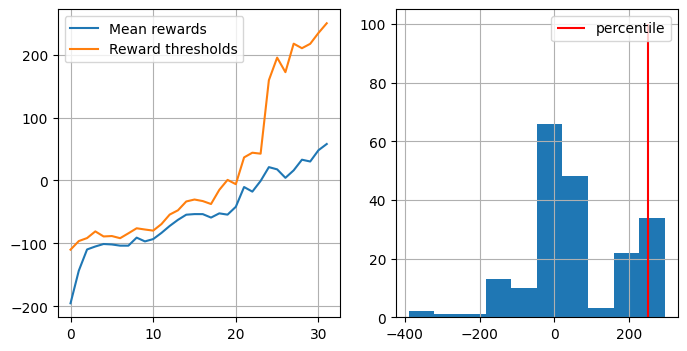

In [ ]:
import numpy as np
log = []
n_sessions = 200  # sample this many sessions
n_rollouts = 1  # Сколько раз играем одной стратегией для усреднения результата
percentile = 70  # discard this percentage of sessions with lowest rewards
for i in range(222):
    interactive_percentile = percentile
    sessions = []
    for _ in range(n_sessions):
        rollouts = [generate_session_for_agent(env, agent, scaler) for __ in range(n_rollouts)]
        _, _, rewards = zip(*rollouts)
        mean_reward = np.mean(rewards)
        all_states = [s for s, _, _ in rollouts]
        all_actions = [a for _, a, _ in rollouts]
        sessions.append((all_states, all_actions, mean_reward))

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    if max(rewards_batch) > 200:
        #Усиленно учимся хорошим результатам.
        interactive_percentile = 90
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, interactive_percentile)
        x = np.concatenate(elite_states)
        y = np.concatenate(elite_actions)
        scaler.partial_fit(x)
        x_scaled = scaler.transform(x)
        for ii in range(12):
            agent.partial_fit(x_scaled, y)
    else:
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, interactive_percentile)
        x = np.concatenate(elite_states)
        y = np.concatenate(elite_actions)
        scaler.partial_fit(x)
        x_scaled = scaler.transform(x)
        agent.partial_fit(x_scaled, y)

    show_progress_fixed(rewards_batch, log, interactive_percentile)

## Вывод видео (отображение в PyCharm сейчас не работает, но зато сразу открывается окно с плеером)

In [ ]:
import sys
import subprocess
import imageio
import numpy as np
from IPython.display import HTML, display
import base64
import os
from PIL import Image

def resize_frame(frame, target_width=608, target_height=400):
    return np.array(Image.fromarray(frame).resize((target_width, target_height), Image.Resampling.LANCZOS))

def record_and_display_agent(env, agent, scaler, filename="lander_final.mp4", fps=30):
    frames = []
    obs, _ = env.reset()
    done = False

    while not done:
        obs_scaled = scaler.transform([obs])
        action = agent.predict(obs_scaled)[0]
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        frame = env.render()
        frame_resized = resize_frame(frame, target_width=608, target_height=400)
        frames.append(frame_resized)

    imageio.mimsave(filename, frames, fps=fps)
    print(f"Видео сохранено: {filename}")

    try:
        video = open(filename, "rb").read()
        video_encoded = base64.b64encode(video).decode('ascii')
        html = f'''
        <video width="400" controls autoplay loop>
            <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
            Your browser does no t support the video tag.
        </video>
        '''
        display(HTML(html))
    except Exception as e:
        print(f"Не удалось встроить видео: {e}")

    try:
        if os.name == 'nt':
            os.startfile(filename)
        elif sys.platform == 'darwin':
            subprocess.run(['open', filename])
        else:
            subprocess.run(['xdg-open', filename])
    except Exception as e:
        print(f"Не удалось открыть видео системой: {e}")

record_and_display_agent(env, agent, scaler)
